### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
dataroot = '/kaggle/input/deepfashion-1/datasets/train_images'


In [3]:
import os

image_files = os.listdir(dataroot)

image_files.sort()

print(image_files[-5:])


['WOMEN-Tees_Tanks-id_00007969-03_7_additional.png', 'WOMEN-Tees_Tanks-id_00007969-04_7_additional.png', 'WOMEN-Tees_Tanks-id_00007976-01_4_full.png', 'WOMEN-Tees_Tanks-id_00007979-03_4_full.png', 'WOMEN-Tees_Tanks-id_00007979-04_4_full.png']


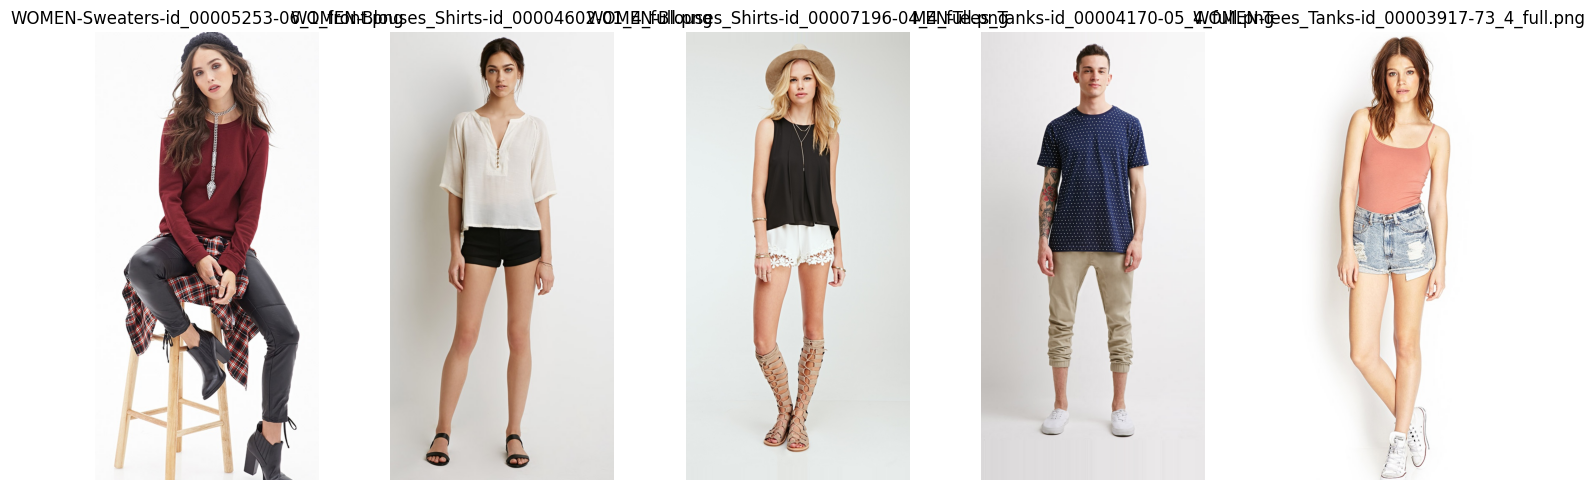

In [4]:
import cv2

image_list = os.listdir(dataroot)

num_images = 5

plt.figure(figsize=(15, 5))

for i in range(num_images):
    img_path = os.path.join(dataroot, image_list[i])  # Construct full image path
    img = cv2.imread(img_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper color display
    plt.subplot(1, num_images, i + 1)  # Create subplots
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Hide the axis
    plt.title(image_list[i])  # Set the title to the image file name

plt.tight_layout()  # Adjust the layout
plt.show()  # Show the plot

In [8]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Define parameters
dataroot = '/kaggle/input/deepfashion-1/datasets/train_images'
data_split_root = '/kaggle/working/data_split'
workers = 4
batch_size = 128
image_size = 64
nc = 3  # Number of channels
nz = 100  # Size of z latent vector (i.e., size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 10
lr = 0.0002
beta1 = 0.5
ngpu = 1


In [10]:
# Prepare data
image_files = os.listdir(dataroot)
image_files.sort()

# Split images into MEN and WOMEN categories
dataroot_men = [f for f in image_files if f.startswith('MEN')]
dataroot_women = [f for f in image_files if f.startswith('WOMEN')]

# Create directories for split data
os.makedirs(os.path.join(data_split_root, 'MEN'), exist_ok=True)
os.makedirs(os.path.join(data_split_root, 'WOMEN'), exist_ok=True)

# Copy images to respective directories
for file_name in dataroot_men:
    shutil.copy(os.path.join(dataroot, file_name), os.path.join(data_split_root, 'MEN', file_name))

for file_name in dataroot_women:
    shutil.copy(os.path.join(dataroot, file_name), os.path.join(data_split_root, 'WOMEN', file_name))


In [11]:
# print(x)
# print(y)

In [12]:
import shutil

os.makedirs('/kaggle/working/data_split/MEN', exist_ok=True)
os.makedirs('/kaggle/working/data_split/WOMEN', exist_ok=True)

for file_name in dataroot_men:
    src_path = os.path.join(dataroot, file_name)  # Original path
    dest_path = os.path.join('/kaggle/working/data_split/MEN', file_name)  # Destination path
    shutil.copy(src_path, dest_path)  # You can use shutil.move to move instead of copy

for file_name in dataroot_women:
    src_path = os.path.join(dataroot, file_name)
    dest_path = os.path.join('/kaggle/working/data_split/WOMEN', file_name)
    shutil.copy(src_path, dest_path)


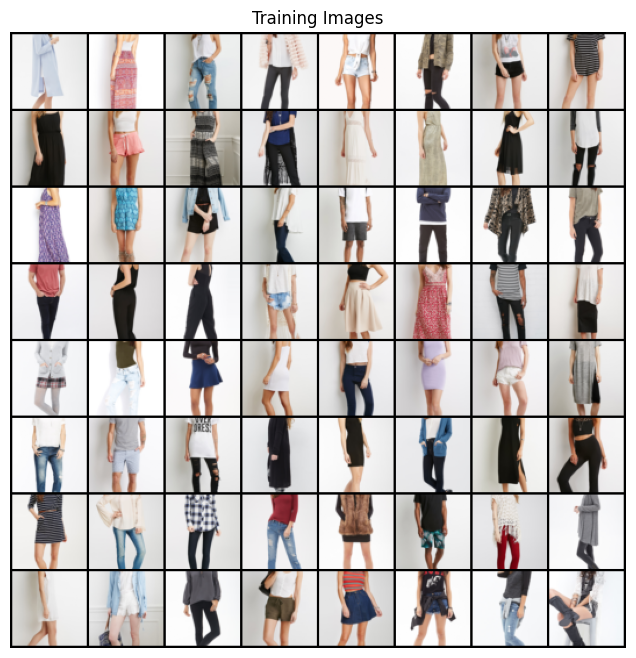

In [13]:
# Load dataset with transformations
dataset = dset.ImageFolder(
    root=data_split_root,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization for 3 channels
    ])
)

# Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Check some images from the dataset
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


In [14]:
# Define weights initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [15]:
# Build Generator
def build_generator(ngpu):
    layers = []
    layers.append(nn.ConvTranspose2d(nz + 1, ngf * 8, 4, 1, 0, bias=False))  # Add label dimension
    layers.append(nn.BatchNorm2d(ngf * 8))
    layers.append(nn.ReLU(True))

    layers.append(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False))
    layers.append(nn.BatchNorm2d(ngf * 4))
    layers.append(nn.ReLU(True))

    layers.append(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False))
    layers.append(nn.BatchNorm2d(ngf * 2))
    layers.append(nn.ReLU(True))

    layers.append(nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False))
    layers.append(nn.BatchNorm2d(ngf))
    layers.append(nn.ReLU(True))

    layers.append(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False))
    layers.append(nn.Tanh())

    model = nn.Sequential(*layers)
    return model

# Build Discriminator
def build_discriminator(ngpu):
    layers = []

    layers.append(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))  # Input should match nc
    layers.append(nn.LeakyReLU(0.2, inplace=True))

    layers.append(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False))
    layers.append(nn.BatchNorm2d(ndf * 2))
    layers.append(nn.LeakyReLU(0.2, inplace=True))

    layers.append(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False))
    layers.append(nn.BatchNorm2d(ndf * 4))
    layers.append(nn.LeakyReLU(0.2, inplace=True))

    layers.append(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False))
    layers.append(nn.BatchNorm2d(ndf * 8))
    layers.append(nn.LeakyReLU(0.2, inplace=True))

    layers.append(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False))
    layers.append(nn.Sigmoid())

    model = nn.Sequential(*layers)

    return model



In [16]:
# Create generator and discriminator
netG = build_generator(ngpu).to(device)
netD = build_discriminator(ngpu).to(device)

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

In [17]:
# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for generating images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

img_list = []
G_losses = []
D_losses = []
iters = 0


In [18]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Get images and labels
        real_cpu, labels = data
        real_cpu = real_cpu.to(device)
        labels = labels.to(device).view(-1, 1)  # Reshape labels for concatenation

        # Train Discriminator
        netD.zero_grad()
        b_size = real_cpu.size(0)

        # Real images
        label = torch.full((b_size,), real_label, device=device).float()
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Expand labels to match dimensions
        labels_expanded = labels.view(b_size, 1, 1, 1)  # Shape: (b_size, 1, 1, 1)

        # Concatenate noise with expanded labels
        noise_with_labels = torch.cat((noise, labels_expanded), 1)  # This should work now
        fake = netG(noise_with_labels)

        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(real_label)  # Fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print losses and save generated images
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save generated images
        if (iters % 500 == 0) or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
            with torch.no_grad():
                label_tensor = torch.full((64, 1, 1, 1), 1, device=device)  # Shape: (64, 1, 1, 1)
                fake = netG(torch.cat((fixed_noise, label_tensor), 1))  # Concatenate along the channel dimension
            img_list.append(vutils.make_grid(fake.detach(), padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/10][0/81]	Loss_D: 1.3832	Loss_G: 3.6281	D(x): 0.5001	D(G(z)): 0.4054 / 0.0383
[0/10][50/81]	Loss_D: 0.7080	Loss_G: 12.5036	D(x): 0.7507	D(G(z)): 0.0000 / 0.0000
[1/10][0/81]	Loss_D: 2.2069	Loss_G: 11.5472	D(x): 0.9659	D(G(z)): 0.8534 / 0.0000
[1/10][50/81]	Loss_D: 0.3372	Loss_G: 5.8428	D(x): 0.7866	D(G(z)): 0.0111 / 0.0038
[2/10][0/81]	Loss_D: 0.5872	Loss_G: 10.5029	D(x): 0.9636	D(G(z)): 0.3761 / 0.0001
[2/10][50/81]	Loss_D: 0.9741	Loss_G: 9.3481	D(x): 0.9774	D(G(z)): 0.5510 / 0.0004
[3/10][0/81]	Loss_D: 0.3762	Loss_G: 4.1853	D(x): 0.8194	D(G(z)): 0.1107 / 0.0319
[3/10][50/81]	Loss_D: 0.4589	Loss_G: 3.1827	D(x): 0.7368	D(G(z)): 0.0477 / 0.0645
[4/10][0/81]	Loss_D: 0.7989	Loss_G: 2.2818	D(x): 0.5629	D(G(z)): 0.0488 / 0.1412
[4/10][50/81]	Loss_D: 0.4298	Loss_G: 3.7317	D(x): 0.8290	D(G(z)): 0.1245 / 0.0443
[5/10][0/81]	Loss_D: 0.4338	Loss_G: 2.9839	D(x): 0.7974	D(G(z)): 0.1061 / 0.0801
[5/10][50/81]	Loss_D: 0.5761	Loss_G: 5.3475	D(x): 0.6303	D(G(z)): 0.0069 / 

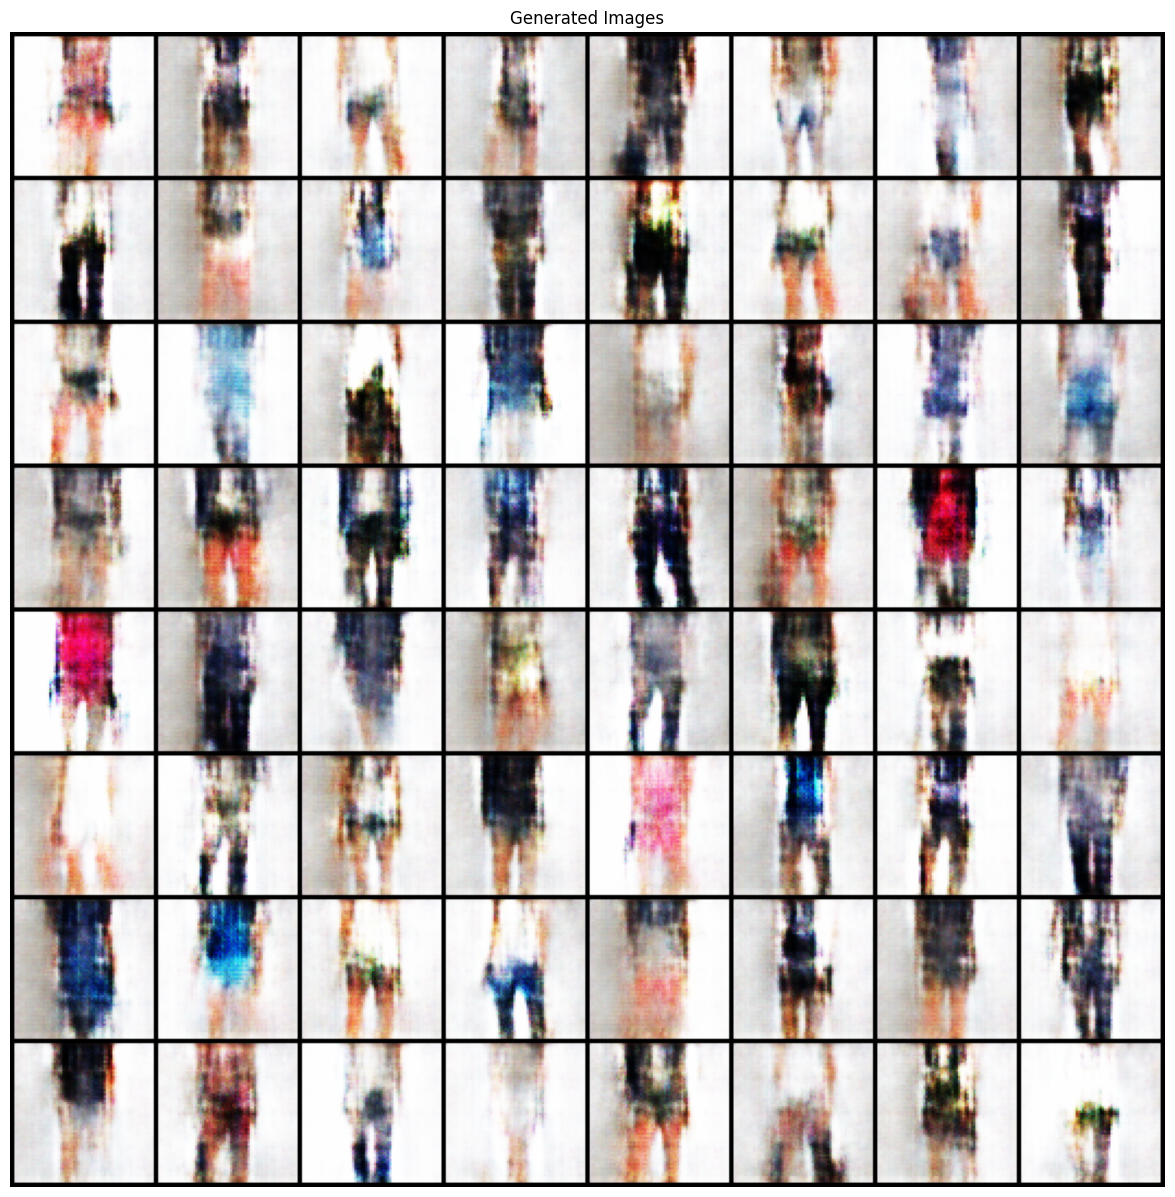

In [19]:
# Plot the generated images
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1].cpu(), (1, 2, 0)))
plt.show()


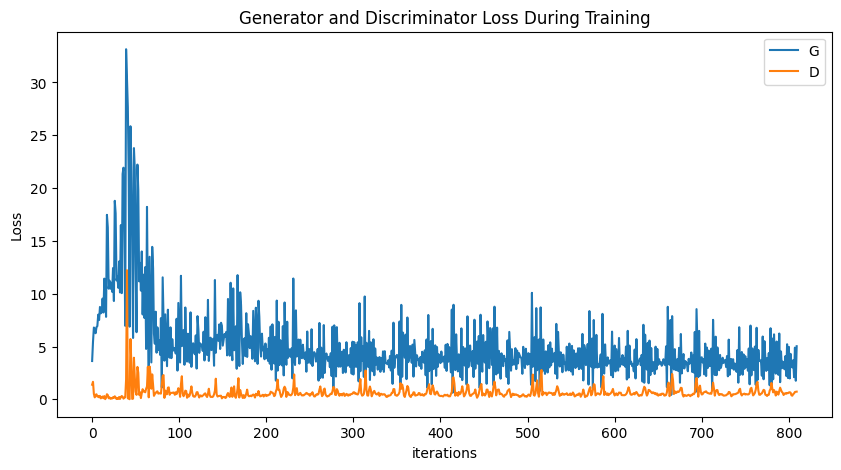

In [20]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [21]:
def save_checkpoint(epoch, modelG, modelD, optimizerG, optimizerD, G_losses, D_losses, iters, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'modelG_state_dict': modelG.state_dict(),
        'modelD_state_dict': modelD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'iters': iters
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}!")

# Function to load the checkpoint
def load_checkpoint(modelG, modelD, optimizerG, optimizerD, filename='checkpoint.pth'):
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        modelG.load_state_dict(checkpoint['modelG_state_dict'])
        modelD.load_state_dict(checkpoint['modelD_state_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
        epoch = checkpoint['epoch']
        G_losses = checkpoint['G_losses']
        D_losses = checkpoint['D_losses']
        iters = checkpoint['iters']
        print(f"Checkpoint loaded from epoch {epoch}.")
        return epoch + 1, G_losses, D_losses, iters  # Start from the next epoch
    else:
        print("No checkpoint found, starting fresh.")
        return 0, [], [], 0  # Start from scratch if no checkpoint found

# Load checkpoint if it exists
start_epoch, G_losses, D_losses, iters = load_checkpoint(netG, netD, optimizerG, optimizerD)


Checkpoint loaded from epoch 89.


/tmp/ipykernel_31/2952649063.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [22]:
# num_epochs = 100

# print("Starting Training Loop...")
# for epoch in range(start_epoch, num_epochs):
#     for i, data in enumerate(dataloader, 0):
#         # Get images and labels
#         real_cpu, labels = data
#         real_cpu = real_cpu.to(device)
#         labels = labels.to(device).view(-1, 1)  # Reshape labels for concatenation

#         # Train Discriminator
#         netD.zero_grad()
#         b_size = real_cpu.size(0)

#         # Real images
#         label = torch.full((b_size,), real_label, device=device).float()
#         output = netD(real_cpu).view(-1)
#         errD_real = criterion(output, label)
#         errD_real.backward()
#         D_x = output.mean().item()

#         # Fake images
#         noise = torch.randn(b_size, nz, 1, 1, device=device)
#         labels_expanded = labels.view(b_size, 1, 1, 1)  # Expand labels
#         noise_with_labels = torch.cat((noise, labels_expanded), 1)  # Concatenate noise with labels
#         fake = netG(noise_with_labels)

#         label.fill_(fake_label)
#         output = netD(fake.detach()).view(-1)
#         errD_fake = criterion(output, label)
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         errD = errD_real + errD_fake
#         optimizerD.step()

#         # Train Generator
#         netG.zero_grad()
#         label.fill_(real_label)  # Fake labels are real for generator cost
#         output = netD(fake).view(-1)
#         errG = criterion(output, label)
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         optimizerG.step()

#         # Print losses and save generated images
#         if i % 50 == 0:
#             print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

#         # Save losses for plotting
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())

#         # Save generated images
#         if (iters % 500 == 0) or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
#             with torch.no_grad():
#                 label_tensor = torch.full((64, 1, 1, 1), 1, device=device)
#                 fake = netG(torch.cat((fixed_noise, label_tensor), 1))  # Concatenate along the channel dimension
#             img_list.append(vutils.make_grid(fake.detach(), padding=2, normalize=True))

#         iters += 1

#     # Save checkpoint at the end of each epoch
#     save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, iters)

# print("Training Finished.")

In [26]:
def load_checkpoint(filename="checkpoint_path"):
    """Load the training model checkpoint."""
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        print(f"Checkpoint loaded from epoch {checkpoint['epoch']}!")
        return checkpoint
    else:
        print("No checkpoint found, starting training from scratch!")
        return None
# Load the last checkpoint if it exists
checkpoint = load_checkpoint()
if checkpoint:
    netG.load_state_dict(checkpoint['modelG_state_dict'])
    netD.load_state_dict(checkpoint['modelD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    iters = checkpoint['iters']
else:
    start_epoch = 0
    G_losses = []
    D_losses = []
    iters = 0

# Continue training from the last saved epoch
num_epochs = 100
print("Starting Training Loop...")
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Get images and labels
        real_cpu, labels = data
        real_cpu = real_cpu.to(device)
        labels = labels.to(device).view(-1, 1)  # Reshape labels for concatenation

        # Train Discriminator
        netD.zero_grad()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device).float()
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        labels_expanded = labels.view(b_size, 1, 1, 1)  # Shape: (b_size, 1, 1, 1)
        noise_with_labels = torch.cat((noise, labels_expanded), 1)  # Concatenate noise with labels
        fake = netG(noise_with_labels)

        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(real_label)  # Fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print losses
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save checkpoint every epoch
#         if i == len(dataloader) - 1:
#             save_checkpoint({
#                 'epoch': epoch,
#                 'modelG_state_dict': netG.state_dict(),
#                 'modelD_state_dict': netD.state_dict(),
#                 'optimizerG_state_dict': optimizerG.state_dict(),
#                 'optimizerD_state_dict': optimizerD.state_dict(),
#                 'G_losses': G_losses,
#                 'D_losses': D_losses,
#                 'iters': iters
#             })
    
        iters += 1

No checkpoint found, starting training from scratch!
Starting Training Loop...
[0/100][0/81]	Loss_D: 0.0529	Loss_G: 5.2212	D(x): 0.9688	D(G(z)): 0.0198 / 0.0127
[0/100][50/81]	Loss_D: 1.0440	Loss_G: 0.8365	D(x): 0.4916	D(G(z)): 0.0618 / 0.5434
[1/100][0/81]	Loss_D: 0.2993	Loss_G: 5.4982	D(x): 0.9632	D(G(z)): 0.1878 / 0.0070
[1/100][50/81]	Loss_D: 0.1385	Loss_G: 3.3936	D(x): 0.9226	D(G(z)): 0.0508 / 0.0575
[2/100][0/81]	Loss_D: 1.0737	Loss_G: 6.9451	D(x): 0.9859	D(G(z)): 0.5763 / 0.0034
[2/100][50/81]	Loss_D: 0.2709	Loss_G: 4.4902	D(x): 0.9103	D(G(z)): 0.1357 / 0.0183
[3/100][0/81]	Loss_D: 0.1211	Loss_G: 5.0640	D(x): 0.9749	D(G(z)): 0.0840 / 0.0109
[3/100][50/81]	Loss_D: 0.3520	Loss_G: 5.8172	D(x): 0.9953	D(G(z)): 0.2497 / 0.0045
[4/100][0/81]	Loss_D: 0.1705	Loss_G: 3.7508	D(x): 0.8596	D(G(z)): 0.0094 / 0.0504
[4/100][50/81]	Loss_D: 0.0804	Loss_G: 3.9478	D(x): 0.9389	D(G(z)): 0.0158 / 0.0341
[5/100][0/81]	Loss_D: 0.0628	Loss_G: 4.9850	D(x): 0.9675	D(G(z)): 0.0282 / 0.0126
[5/100][50/81]

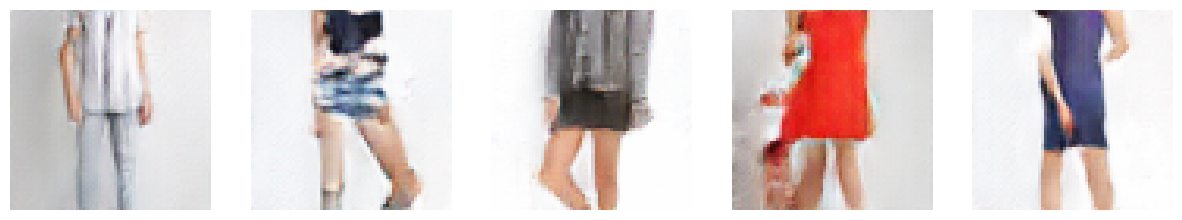

In [27]:
def show_generated_images(fake_images, num_images=5):
    """Display the generated images."""
    # Detach and move the fake images to the CPU
    fake_images = fake_images.detach().cpu().numpy()
    fake_images = (fake_images + 1) / 2  # Rescale [-1, 1] to [0, 1]

    # Plot the images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axs[i].imshow(np.transpose(fake_images[i], (1, 2, 0)))  # Convert from CHW to HWC
        axs[i].axis('off')
    plt.show()

    
show_generated_images(fake, num_images=5)


In [28]:
save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, iters, filename='final_checkpoint.pth')

print("Training Completed and Final Model Saved.")

Checkpoint saved at epoch 99!
Training Completed and Final Model Saved.


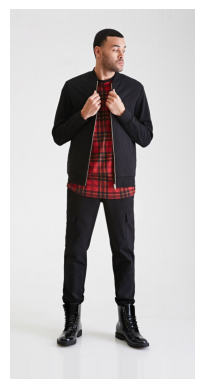

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Load the image from the specified path
image_path = '/kaggle/input/deepfashion-1/datasets/test_images/MEN-Jackets_Vests-id_00000393-01_4_full.png'

# Open the image using PIL (Python Imaging Library)
img = Image.open(image_path)

# Apply any transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image
    transforms.ToTensor(),  # Convert to tensor
])

# Transform the image
img_tensor = transform(img)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


/tmp/ipykernel_31/719331508.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


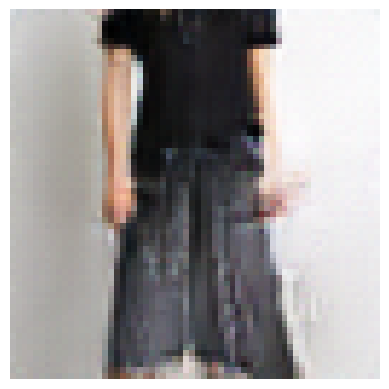

Generated image saved as 'generated_image.png'


In [38]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils

# Load the trained model
# Assuming your trained model is saved as './gan_model_epoch_99.pth'
checkpoint_path = './final_checkpoint.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load your Generator model
netG = build_generator(ngpu).to(device)  # Assuming `build_generator` is defined
checkpoint = torch.load(checkpoint_path)
netG.load_state_dict(checkpoint['modelG_state_dict'])

# Function to load and preprocess the input image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize image
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
    ])
    
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to generate an image using the model
def generate_image(input_image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        noise = torch.randn(1, nz, 1, 1, device=device)  # Generate random noise
        labels = torch.tensor([[1]]).float().to(device)  # Assuming label 1 is used for the generation task
        
        # Concatenate noise with label
        noise_with_label = torch.cat((noise, labels.view(1, 1, 1, 1)), 1)
        
        generated_image = model(noise_with_label)  # Pass through generator
        return generated_image

# Define the image path
image_path = '/kaggle/input/deepfashion-1/datasets/test_images/MEN-Jackets_Vests-id_00000393-01_4_full.png'

# Load the input image
input_image = load_image(image_path).to(device)

# Generate a new image using the model
generated_image = generate_image(input_image, netG)

# Save and display the generated image
generated_image = generated_image.cpu()  # Move to CPU for displaying/saving
generated_image = vutils.make_grid(generated_image, normalize=True)

# Display the generated image
plt.imshow(np.transpose(generated_image, (1, 2, 0)))
plt.axis('off')
plt.show()

# Save the generated image
vutils.save_image(generated_image, 'generated_image.png')
print("Generated image saved as 'generated_image.png'")


In [44]:
import os
import torch

def load_checkpoint(filename="final_checkpoint.pth"):
    """Load the training model checkpoint."""
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        print(f"Checkpoint loaded from epoch {checkpoint['epoch']}!")
        return checkpoint
    else:
        print("No checkpoint found, starting training from scratch!")
        return None

# Load the last checkpoint if it exists
checkpoint = load_checkpoint()
if checkpoint:
    netG.load_state_dict(checkpoint['modelG_state_dict'])
    netD.load_state_dict(checkpoint['modelD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    iters = checkpoint['iters']
else:
    start_epoch = 0
    G_losses = []
    D_losses = []
    iters = 0

# Adjust total number of epochs for continued training
total_epochs = 200  # Set this to the total number of epochs (including already completed ones)
num_epochs = total_epochs

print("Starting Training Loop...")

for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Get images and labels
        real_cpu, labels = data
        real_cpu = real_cpu.to(device)
        labels = labels.to(device).view(-1, 1)  # Reshape labels for concatenation

        # Train Discriminator
        netD.zero_grad()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device).float()
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        labels_expanded = labels.view(b_size, 1, 1, 1)  # Shape: (b_size, 1, 1, 1)
        noise_with_labels = torch.cat((noise, labels_expanded), 1)  # Concatenate noise with labels
        fake = netG(noise_with_labels)

        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(real_label)  # Fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print losses
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

# Save checkpoint again at the end of training
save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, iters, filename='final_checkpoint.pth')

print("Training Completed and Final Model Saved.")


Checkpoint loaded from epoch 99!
Starting Training Loop...


/tmp/ipykernel_31/1931230433.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


[100/200][0/81]	Loss_D: 0.0156	Loss_G: 6.1426	D(x): 0.9930	D(G(z)): 0.0084 / 0.0057
[100/200][50/81]	Loss_D: 0.0126	Loss_G: 6.2348	D(x): 0.9915	D(G(z)): 0.0039 / 0.0052
[101/200][0/81]	Loss_D: 0.0065	Loss_G: 6.8944	D(x): 0.9977	D(G(z)): 0.0042 / 0.0026
[101/200][50/81]	Loss_D: 0.0055	Loss_G: 7.3511	D(x): 0.9967	D(G(z)): 0.0022 / 0.0022
[102/200][0/81]	Loss_D: 0.0041	Loss_G: 7.2843	D(x): 0.9985	D(G(z)): 0.0026 / 0.0019
[102/200][50/81]	Loss_D: 0.0035	Loss_G: 7.8798	D(x): 0.9977	D(G(z)): 0.0012 / 0.0010
[103/200][0/81]	Loss_D: 0.0021	Loss_G: 7.9699	D(x): 0.9987	D(G(z)): 0.0008 / 0.0008
[103/200][50/81]	Loss_D: 0.0038	Loss_G: 7.3114	D(x): 0.9988	D(G(z)): 0.0026 / 0.0019
[104/200][0/81]	Loss_D: 0.0041	Loss_G: 7.5708	D(x): 0.9983	D(G(z)): 0.0024 / 0.0018
[104/200][50/81]	Loss_D: 0.0013	Loss_G: 8.2887	D(x): 0.9997	D(G(z)): 0.0010 / 0.0007
[105/200][0/81]	Loss_D: 0.0016	Loss_G: 8.5500	D(x): 0.9991	D(G(z)): 0.0007 / 0.0006
[105/200][50/81]	Loss_D: 0.0018	Loss_G: 8.6723	D(x): 0.9988	D(G(z)): 0.

In [45]:
save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, iters, filename='final_checkpoint.pth')

print("Training Completed and Final Model Saved.")

Checkpoint saved at epoch 199!
Training Completed and Final Model Saved.


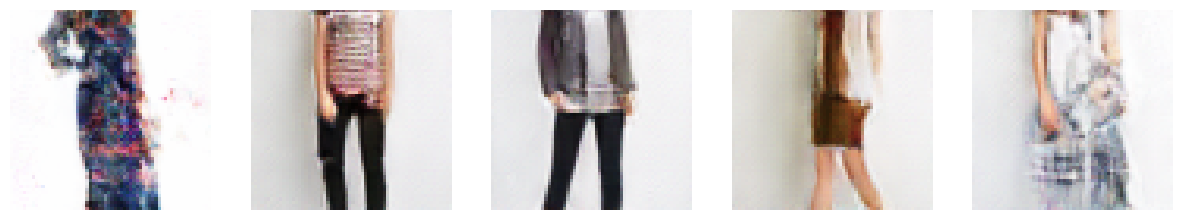

In [46]:
def show_generated_images(fake_images, num_images=5):
    """Display the generated images."""
    # Detach and move the fake images to the CPU
    fake_images = fake_images.detach().cpu().numpy()
    fake_images = (fake_images + 1) / 2  # Rescale [-1, 1] to [0, 1]

    # Plot the images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axs[i].imshow(np.transpose(fake_images[i], (1, 2, 0)))  # Convert from CHW to HWC
        axs[i].axis('off')
    plt.show()

    
show_generated_images(fake, num_images=5)


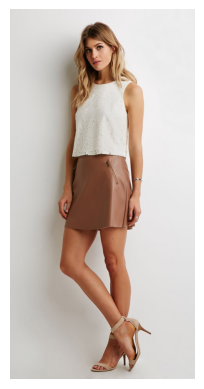

In [121]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Load the image from the specified path
image_path = '/kaggle/input/deepfashion-1/datasets/test_images/WOMEN-Blouses_Shirts-id_00003777-02_4_full.png'

# Open the image using PIL (Python Imaging Library)
img = Image.open(image_path)

# Apply any transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image
    transforms.ToTensor(),  # Convert to tensor
])

# Transform the image
img_tensor = transform(img)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


/tmp/ipykernel_31/606568835.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


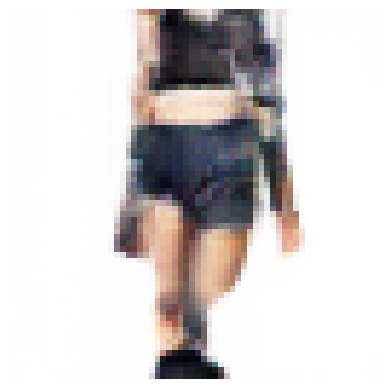

Generated image saved as 'generated_image.png'


In [128]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils

# Load the trained model
# Assuming your trained model is saved as './gan_model_epoch_99.pth'
checkpoint_path = './final_checkpoint.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load your Generator model
netG = build_generator(ngpu).to(device)  # Assuming `build_generator` is defined
checkpoint = torch.load(checkpoint_path)
netG.load_state_dict(checkpoint['modelG_state_dict'])

# Function to load and preprocess the input image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize image
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
    ])
    
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to generate an image using the model
def generate_image(input_image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        noise = torch.randn(1, nz, 1, 1, device=device)  # Generate random noise
        labels = torch.tensor([[1]]).float().to(device)  # Assuming label 1 is used for the generation task
        
        # Concatenate noise with label
        noise_with_label = torch.cat((noise, labels.view(1, 1, 1, 1)), 1)
        
        generated_image = model(noise_with_label)  # Pass through generator
        return generated_image

# Define the image path
image_path = '/kaggle/input/deepfashion-1/datasets/test_images/WOMEN-Blouses_Shirts-id_00003777-02_4_full.png'

# Load the input image
input_image = load_image(image_path).to(device)

# Generate a new image using the model
generated_image = generate_image(input_image, netG)

# Save and display the generated image
generated_image = generated_image.cpu()  # Move to CPU for displaying/saving
generated_image = vutils.make_grid(generated_image, normalize=True)

# Display the generated image
plt.imshow(np.transpose(generated_image, (1, 2, 0)))
plt.axis('off')
plt.show()

# Save the generated image
vutils.save_image(generated_image, 'generated_image.png')
print("Generated image saved as 'generated_image.png'")


In [95]:
x=1
print(x)

1


In [148]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
import numpy as np
from IPython.display import display
from ipywidgets import FileUpload

# Load the trained model
checkpoint_path = './final_checkpoint.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load your Generator model
netG = build_generator(ngpu).to(device)  # Assuming `build_generator` is defined
checkpoint = torch.load(checkpoint_path)
netG.load_state_dict(checkpoint['modelG_state_dict'])

# Function to load and preprocess the input image
def load_image(image_data):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize image
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
    ])
    
    img = Image.open(image_data)
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to generate an image using the model
def generate_image(input_image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        noise = torch.randn(1, nz, 1, 1, device=device)  # Generate random noise
        labels = torch.tensor([[1]]).float().to(device)  # Assuming label 1 is used for the generation task
        
        # Concatenate noise with label
        noise_with_label = torch.cat((noise, labels.view(1, 1, 1, 1)), 1)
        
        generated_image = model(noise_with_label)  # Pass through generator
        return generated_image

# Define a file upload widget
upload_widget = FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    uploaded_file = list(change['new'].values())[0]
    image_data = uploaded_file['content']  # Get the content of the uploaded file
    
    # Load the input image
    input_image = load_image(image_data).to(device)
    
    # Generate a new image using the model
    generated_image = generate_image(input_image, netG)
    
    # Save and display the generated image
    generated_image = generated_image.cpu()  # Move to CPU for displaying/saving
    generated_image = vutils.make_grid(generated_image, normalize=True)

    # Display the generated image
    plt.imshow(np.transpose(generated_image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
    # Save the generated image
    vutils.save_image(generated_image, 'generated_image.png')
    print("Generated image saved as 'generated_image.png'")

# Trigger the upload action
upload_widget.observe(on_upload_change, names='value')
display(upload_widget)


/tmp/ipykernel_31/2009376837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


FileUpload(value={}, accept='image/*', description='Upload')

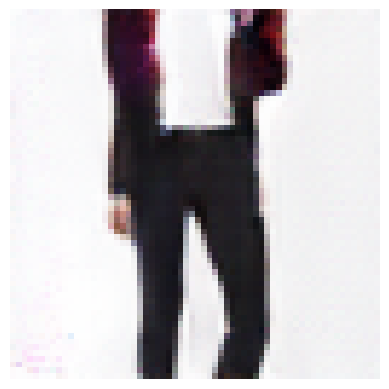

In [158]:
generated_image = generate_image(on_upload_change, netG)

# Save and display the generated image
generated_image = generated_image.cpu()  # Move to CPU for displaying/saving
generated_image = vutils.make_grid(generated_image, normalize=True)

# Display the generated image
plt.imshow(np.transpose(generated_image, (1, 2, 0)))
plt.axis('off')
plt.show()


In [162]:
# import torch
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# from PIL import Image
# import torchvision.utils as vutils
# import numpy as np
# import tkinter as tk
# from tkinter import filedialog
# import io

# # Load the trained model
# checkpoint_path = './final_checkpoint.pth'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load your Generator model (ensure `build_generator` and `ngpu` are defined elsewhere)
# netG = build_generator(ngpu).to(device)  # Assuming `build_generator` is defined
# checkpoint = torch.load(checkpoint_path)
# netG.load_state_dict(checkpoint['modelG_state_dict'])

# # Function to load and preprocess the input image
# def load_image(image_path):
#     transform = transforms.Compose([
#         transforms.Resize((image_size, image_size)),  # Resize image
#         transforms.ToTensor(),  # Convert to tensor
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
#     ])
    
#     img = Image.open(image_path)  # Open image from file path
#     img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
#     return img_tensor

# # Function to generate an image using the model
# def generate_image(input_image, model):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         noise = torch.randn(1, nz, 1, 1, device=device)  # Generate random noise
#         labels = torch.tensor([[1]]).float().to(device)  # Assuming label 1 is used for the generation task
        
#         # Concatenate noise with label
#         noise_with_label = torch.cat((noise, labels.view(1, 1, 1, 1)), 1)
        
#         generated_image = model(noise_with_label)  # Pass through generator
#         return generated_image

# # Function to open file dialog and select image
# def upload_image():
#     root = tk.Tk()
#     root.withdraw()  # Hide the main window
#     image_path = filedialog.askopenfilename()  # Open file dialog to select image
#     if image_path:
#         print(f"Image selected: {image_path}")
#         input_image = load_image(image_path).to(device)
        
#         # Generate a new image using the model
#         generated_image = generate_image(input_image, netG)
        
#         # Save and display the generated image
#         generated_image = generated_image.cpu()  # Move to CPU for displaying/saving
#         generated_image = vutils.make_grid(generated_image, normalize=True)

#         # Display the generated image
#         plt.imshow(np.transpose(generated_image.numpy(), (1, 2, 0)))
#         plt.axis('off')
#         plt.show()
        
#         # Save the generated image
#         vutils.save_image(generated_image, 'generated_image.png')
#         print("Generated image saved as 'generated_image.png'")

# # Call the image upload function
# upload_image()


In [167]:
import torch

def save_model_as_pickle(model, optimizer, epoch, G_losses, D_losses, filename='model.pkl'):
    """Save the model, optimizer state, and losses as a pickle file."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'G_losses': G_losses,
        'D_losses': D_losses,
    }
    with open(filename, 'wb') as f:
        torch.save(checkpoint, f)
    print(f'Model and optimizer state saved to {filename}')

# Example usage
save_model_as_pickle(netG, optimizerG, epoch, G_losses, D_losses, filename='generator_model.pkl')
save_model_as_pickle(netD, optimizerD, epoch, G_losses, D_losses, filename='discriminator_model.pkl')


Model and optimizer state saved to generator_model.pkl
Model and optimizer state saved to discriminator_model.pkl


In [168]:
import torch

def save_model_as_pickle(model, optimizer, epoch, G_losses, D_losses, filename='model.pkl'):
    """Save the model, optimizer state, and losses as a pickle file."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'G_losses': G_losses,
        'D_losses': D_losses,
    }
    with open(filename, 'wb') as f:
        torch.save(checkpoint, f)
    print(f'Model and optimizer state saved to {filename}')

# Example usage
save_model_as_pickle(netG, optimizerG, epoch, G_losses, D_losses, filename='generator_model.pkl')
save_model_as_pickle(netD, optimizerD, epoch, G_losses, D_losses, filename='discriminator_model.pkl')


Model and optimizer state saved to generator_model.pkl
Model and optimizer state saved to discriminator_model.pkl


In [173]:
import os

# Path to the file you want to delete
file_to_delete = '/kaggle/working/models.zip'

# Check if the file exists and delete it
if os.path.exists(file_to_delete):
    os.remove(file_to_delete)
    print(f"Deleted: {file_to_delete}")
else:
    print(f"File not found: {file_to_delete}")


Deleted: /kaggle/working/models.zip


In [174]:
save_model_as_pickle(netG, optimizerG, epoch, G_losses, D_losses, filename='/kaggle/working/generator_model.pkl')
save_model_as_pickle(netD, optimizerD, epoch, G_losses, D_losses, filename='/kaggle/working/discriminator_model.pkl')


Model and optimizer state saved to /kaggle/working/generator_model.pkl
Model and optimizer state saved to /kaggle/working/discriminator_model.pkl


In [175]:
import torch

# Re-save the generator and discriminator models
torch.save(netG.state_dict(), '/kaggle/working/generator_model.pkl')
torch.save(netD.state_dict(), '/kaggle/working/discriminator_model.pkl')


In [176]:
import os

working_dir = '/kaggle/working/'
files = os.listdir(working_dir)
print(f"Files in {working_dir}:")
for file in files:
    print(file)


Files in /kaggle/working/:
generator_model.pkl
data_split
checkpoint.pth
.virtual_documents
state.db
generated_image.png
final_checkpoint.pth
discriminator_model.pkl
